In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, pairwise_distances_argmin_min
from sklearn.utils import resample
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from sklearn.cluster import KMeans
import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
print(torch.__version__)

2.1.0+cu121


In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

100%|██████████| 9912422/9912422 [00:00<00:00, 96111478.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57766186.85it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 33925542.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9333919.04it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
len(mnist_trainset), len(mnist_testset)

(60000, 10000)

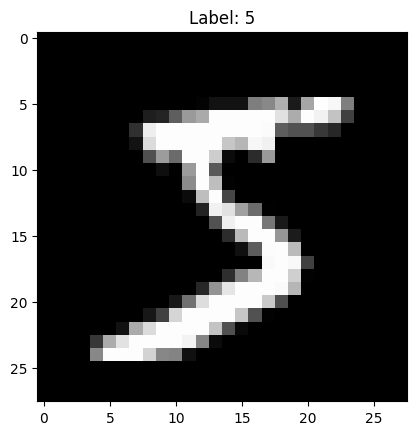

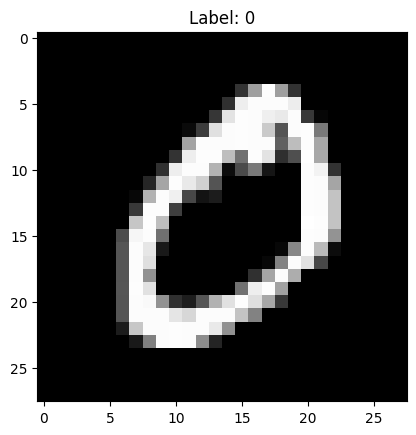

In [8]:
for i in range(0,2):
  image, label = mnist_trainset[i]
  #print(label)
  plt.imshow(image, cmap='gray')
  plt.title(f"Label: {label}")
  plt.show()

## Evaluation Metrics

In [9]:
#Balanced Error Rate
def ber(A,B):
    TP = [(a==b and a==1) for a,b in zip(A,B)]
    TP = sum(TP)
    TN = [a==b and a==0 for a,b in zip(A,B)]
    TN = sum(TN)
    FP = [a!=b and b==1 for a,b in zip(A,B)]
    FP = sum(FP)
    FN = [a!=b and b==0 for a,b in zip(A,B)]
    FN = sum(FN)
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    BER = 1 - (TPR+TNR)/2
    return BER

## Train-Test Split



In [10]:
#Implementation of Baseline, K-Means, MCNN

In [11]:
#Test-Train split
X_train = mnist_trainset.data.numpy().reshape(-1, 28*28)
y_train = mnist_trainset.targets.numpy()

X_test = mnist_testset.data.numpy().reshape(-1, 28*28)
y_test = mnist_testset.targets.numpy()

In [12]:
#Dataframe to store metrics
accuracy_df = pd.DataFrame(columns=["M", "Random", "k-means", "MCNN"])
ber_df = pd.DataFrame(columns=["M", "Random", "k-means", "MCNN"])
f1_df = pd.DataFrame(columns=["M", "Random", "k-means", "MCNN"])
time_df = pd.DataFrame(columns=["M", "Random", "k-means", "MCNN"])

## Baseline - Random selection

In [13]:
#Baseline Model
def baseline_knn(X_train_resampled, y_train_resampled, X_test, y_test, k):
  X_train_resampled, y_train_resampled = resample(X_train, y_train, n_samples=k, random_state=42)
  knn_classifier_baseline = KNeighborsClassifier(n_neighbors=1)
  knn_classifier_baseline.fit(X_train_resampled, y_train_resampled)

  # Evaluate the model (Baseline)
  y_pred_baseline = knn_classifier_baseline.predict(X_test)
  accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
  ber_baseline = ber(y_test, y_pred_baseline)
  f1_bs = f1_score(y_test, y_pred_baseline, average='weighted')
  return accuracy_baseline, ber_baseline, f1_bs

In [14]:
for k in [100, 1000, 5000, 10000]:
  # Call the baseline function
  start_time = time.time()
  accuracy_bs, ber_baseline, f1_bs = baseline_knn(X_train, y_train, X_test, y_test, k)
  end_time = time.time()
  execution_time = end_time - start_time

  accuracy_df = accuracy_df.append({"M": k, "Random": accuracy_bs}, ignore_index=True)
  ber_df = ber_df.append({"M": k, "Random": ber_baseline}, ignore_index=True)
  f1_df = f1_df.append({"M": k, "Random": f1_bs}, ignore_index=True)
  time_df = time_df.append({"M": k, "Random": execution_time}, ignore_index=True)

  #Display Baseline metric values for each k
  print("K =", k)
  print("BER:", round(ber_baseline, 2))
  print("Accuracy:", round(accuracy_bs, 2))
  print("F1 Score:", round(f1_bs, 2))
  print("execution_time:", execution_time)
  print("\n")

K = 100
BER: 0.22
Accuracy: 0.69
F1 Score: 0.67
execution_time: 0.9810144901275635


K = 1000
BER: 0.11
Accuracy: 0.87
F1 Score: 0.87
execution_time: 1.8537969589233398


K = 5000
BER: 0.06
Accuracy: 0.93
F1 Score: 0.93
execution_time: 5.7748517990112305


K = 10000
BER: 0.05
Accuracy: 0.95
F1 Score: 0.95
execution_time: 8.12675929069519




## Modified Condensed Nearest Neighbor

In [15]:
#MCNN
def modified_condensed_nearest_neighbor_3(X_train, y_train, k):
    X_resampled = [X_train[0]]
    y_resampled = [y_train[0]]

    for i in range(1, len(X_train)):
        x_i = X_train[i]
        y_i = y_train[i]

        # Check if the instance is misclassified by the current subset
        knn_subset = KNeighborsClassifier(n_neighbors=1)
        knn_subset.fit(X_resampled, y_resampled)
        y_pred_i = knn_subset.predict([x_i])

        if y_pred_i != y_i:
            # Add the misclassified instance to the subset
            X_resampled.append(x_i)
            y_resampled.append(y_i)

        # Check if the subset size has reached the desired k
        if len(X_resampled) == k:
            break

    return np.array(X_resampled), np.array(y_resampled)

In [16]:
def mcnn_knn_3(X_train, y_train, X_test, y_test, k):
    # Obtain the condensed subset using MCNN
    X_train_resampled, y_train_resampled = modified_condensed_nearest_neighbor_3(X_train, y_train, k)

    # Train the KNN classifier with the condensed subset
    knn_classifier_mcnn = KNeighborsClassifier(n_neighbors=1)
    knn_classifier_mcnn.fit(X_train_resampled, y_train_resampled)

    # Evaluate the model (MCNN)
    y_pred_mcnn = knn_classifier_mcnn.predict(X_test)
    accuracy_mcnn = accuracy_score(y_test, y_pred_mcnn)
    ber_mcnn = ber(y_test, y_pred_mcnn)
    f1_mcnn = f1_score(y_test, y_pred_mcnn, average='weighted')

    return accuracy_mcnn, ber_mcnn, f1_mcnn

In [17]:
for k in [100, 1000, 5000, 10000]:
  start_time = time.time()
  accuracy_mcnn, ber_mcnn, f1_mcnn = mcnn_knn_3(X_train, y_train, X_test, y_test, k)
  end_time = time.time()
  execution_time = end_time - start_time

  accuracy_df = accuracy_df.append({"M": k, "MCNN": accuracy_mcnn}, ignore_index=True)
  ber_df = ber_df.append({"M": k, "MCNN": ber_mcnn}, ignore_index=True)
  f1_df = f1_df.append({"M": k, "MCNN": f1_mcnn}, ignore_index=True)
  time_df = time_df.append({"M": k, "MCNN": execution_time}, ignore_index=True)

  #Display Metric Value
  print("K =", k)
  print("BER: ", round(ber_mcnn, 2))
  print("Accuracy: ", round(accuracy_mcnn, 2))
  print("F1-Score: ", round(f1_mcnn, 2))
  print("execution_time:", execution_time)
  print("\n")

K = 100
BER:  0.16
Accuracy:  0.76
F1-Score:  0.75
execution_time: 5.232117414474487


K = 1000
BER:  0.07
Accuracy:  0.88
F1-Score:  0.88
execution_time: 63.06704545021057


K = 5000
BER:  0.04
Accuracy:  0.93
F1-Score:  0.93
execution_time: 1344.7105667591095


K = 10000
BER:  0.04
Accuracy:  0.93
F1-Score:  0.93
execution_time: 1261.3294982910156




## K-Means Clustering

In [18]:
#K-Means
def kmeans_nn (X_train, y_train, M):
  #prototypes holds the indexes of the training set that will be used as prototypes
  prototype = []
  classes = len(np.unique(y_train))
  num_clusters = int(M/classes)
  x_index = [ [] for _ in range(classes) ]
  for i in range(len(y_train)):
    x_index[y_train[i]].append(i)
  iter = 0
  for x in x_index:
    cc = KMeans(n_clusters = num_clusters).fit(X_train[x]).cluster_centers_
    pt, _ = pairwise_distances_argmin_min(cc,X_train)
    prototype.append(pt)
  prototype = np.concatenate(prototype).ravel()
  return X_train[prototype], y_train[prototype]

In [19]:
def kmeans_knn(X_train, y_train, X_test, y_test, k):
  # Obtain the prototype subset using K-means clustering
  X_prototype, y_prototype = kmeans_nn(X_train, y_train, k)
  #prototype = kmeans_nn(X_train, y_train, k)

  # Train the KNN classifier with the prototype subset
  knn_classifier_kmeans = KNeighborsClassifier(n_neighbors=1)
  knn_classifier_kmeans.fit(X_prototype, y_prototype)

  # Evaluate the model
  y_pred_kmeans = knn_classifier_kmeans.predict(X_test)

  # Calculate evaluation metrics
  accuracy_km = accuracy_score(y_test, y_pred_kmeans)
  ber_km = ber(y_test, y_pred_kmeans)
  f1_km = f1_score(y_test, y_pred_kmeans, average='weighted')

  return accuracy_km, ber_km, f1_km

In [20]:
for k in [100, 1000, 5000, 10000]:
  start_time = time.time()
  accuracy_km, ber_km, f1_km = kmeans_knn(X_train, y_train, X_test, y_test, k)
  end_time = time.time()
  execution_time = start_time - end_time

  accuracy_df = accuracy_df.append({"M": k, "k-means": accuracy_km}, ignore_index=True)
  ber_df = ber_df.append({"M": k, "k-means": ber_km}, ignore_index=True)
  f1_df = f1_df.append({"M": k, "k-means": f1_km}, ignore_index=True)
  time_df = time_df.append({"M": k, "k-means": execution_time}, ignore_index=True)

  #Display Metric Value
  print("K =", k)
  print("BER: ", round(ber_km, 2))
  print("Accuracy: ", round(accuracy_km, 2))
  print("F1-Score: ", round(f1_km, 2))
  print("\n")

K = 100
BER:  0.11
Accuracy:  0.86
F1-Score:  0.86


K = 1000
BER:  0.07
Accuracy:  0.93
F1-Score:  0.93


K = 5000
BER:  0.06
Accuracy:  0.95
F1-Score:  0.95


K = 10000
BER:  0.05
Accuracy:  0.95
F1-Score:  0.95




In [21]:
accuracy_df = accuracy_df.groupby('M').agg({'Random': 'first', 'k-means': 'first', 'MCNN': 'first'}).reset_index()
ber_df = ber_df.groupby('M').agg({'Random': 'first', 'k-means': 'first', 'MCNN': 'first'}).reset_index()
f1_df = f1_df.groupby('M').agg({'Random': 'first', 'k-means': 'first', 'MCNN': 'first'}).reset_index()
time_df = time_df.groupby('M').agg({'Random': 'first', 'k-means': 'first', 'MCNN': 'first'}).reset_index()

In [23]:
accuracy_df.to_csv("accuracy.csv")
ber_df.to_csv("ber.csv")
f1_df.to_csv("f1.csv")
time_df.to_csv("exec_time.csv")

## Visualization

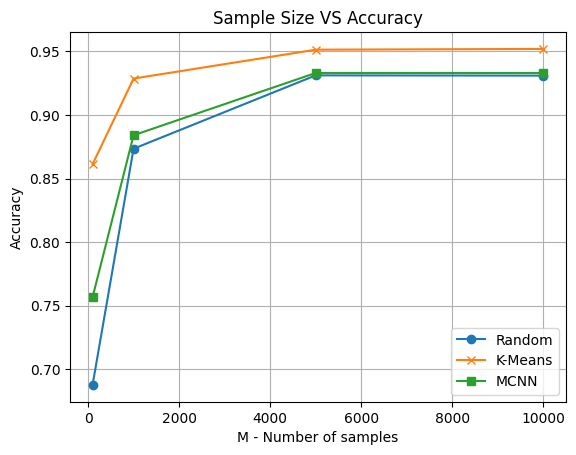

In [36]:
plt.plot(accuracy_df['M'], accuracy_df['Random'], marker='o', label='Random')
plt.plot(accuracy_df['M'], accuracy_df['k-means'], marker='x', label='K-Means')
plt.plot(accuracy_df['M'], accuracy_df['MCNN'], marker='s' , label='MCNN')


plt.xlabel('M - Number of samples')
plt.ylabel('Accuracy')
plt.title('Sample Size VS Accuracy')
plt.legend()
plt.grid(True)
plt.show()

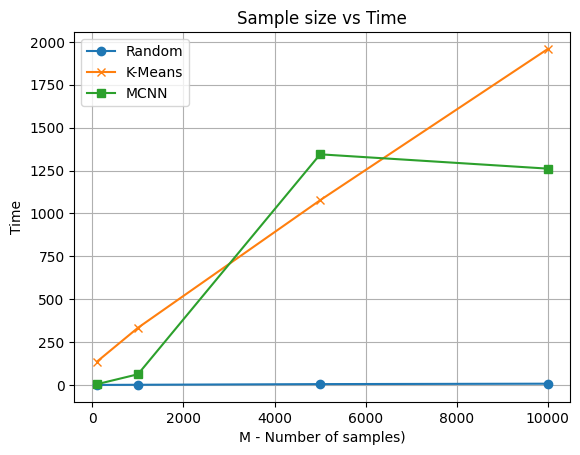

In [32]:
plt.plot(time_df['M'], time_df['Random'], marker='o', label='Random')
plt.plot(time_df['M'], time_df['k-means'], marker='x', label='K-Means')
plt.plot(time_df['M'], time_df['MCNN'], marker='s' , label='MCNN')

plt.xlabel('M - Number of samples)')
plt.ylabel('Time')
plt.title('Sample size vs Time')
plt.legend()
plt.grid(True)
plt.show()

# THE END :)